# Keystroke Dynamics Authentication System
## Complete ML Pipeline for User Authentication

**Features:**
- Data Exploration & Visualization
- Feature Selection (MI, RFE, PCA, SelectKBest)
- Binary Classification (Single & Multiple Authorized Users)
- Multi-Class Classification
- Performance Analysis With/Without Feature Selection
- ML Algorithm Comparison (12+ algorithms)
- Ensemble Methods (Voting, Stacking, Bagging, Boosting)

## Cell 1: Install Dependencies (Run if needed)

In [ ]:
# Uncomment and run if packages are not installed
# !pip install -q xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn

## Cell 2: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.base import clone

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier,
                              VotingClassifier, StackingClassifier, BaggingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, auc, accuracy_score, precision_score, 
                             recall_score, f1_score, ConfusionMatrixDisplay)

# XGBoost & LightGBM
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("✗ XGBoost not available")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✓ LightGBM available")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("✗ LightGBM not available")

warnings.filterwarnings('ignore')
np.random.seed(42)
RANDOM_STATE = 42

print("\n✓ All imports successful!")

✓ XGBoost available
✓ LightGBM available

✓ All imports successful!


## Cell 3: Load Data

**Update the `DATA_PATH` to your file location.**

For Google Colab:
```python
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/your_folder/fixed-text.csv"
```

In [2]:
# ========== UPDATE THIS PATH ==========
DATA_PATH = "fixed-text.csv"  # <-- Change to your file path
# ======================================

# Read CSV with encoding handling
def read_csv_safely(path):
    for enc in [None, "utf-8", "utf-8-sig", "latin-1"]:
        try:
            return pd.read_csv(path, encoding=enc) if enc else pd.read_csv(path)
        except:
            continue
    raise RuntimeError(f"Could not read {path}")

# Load data
df_raw = read_csv_safely(DATA_PATH)
print(f"✓ Loaded data: {df_raw.shape}")
df_raw.head()

✓ Loaded data: (19772, 50)


,participant,session,repetition,DU.v.v,DD.v.p,DU.v.p,UD.v.p,UU.v.p,DU.p.p,DD.p.w,...,DU.r.k,UD.r.k,UU.r.k,DU.k.k.1,DD.k.b,DU.k.b,UD.k.b,UU.k.b,DU.b.b,total time
0,p001,1,1,0.129,1.917,1.804,2.046,1.933,0.113,0.719,...,1.289,1.509,1.423,0.086,0.450,0.352,0.536,0.438,0.098,10.101
1,p001,1,2,0.112,0.192,0.096,0.304,0.208,0.096,0.448,...,0.921,1.135,1.056,0.079,0.418,0.336,0.497,0.415,0.082,5.768
2,p001,1,3,0.088,0.253,0.182,0.341,0.270,0.071,1.536,...,1.066,1.271,1.194,0.077,0.448,0.352,0.525,0.429,0.096,7.877
3,p001,1,4,0.104,0.323,0.233,0.427,0.337,0.090,0.912,...,0.927,1.129,1.063,0.066,0.418,0.330,0.484,0.396,0.088,5.443
4,p001,1,5,0.107,0.188,0.100,0.295,0.207,0.088,0.858,...,1.237,1.423,1.344,0.079,0.457,0.369,0.536,0.448,0.088,5.284


## Cell 4: Data Preprocessing

In [3]:
# Get timing feature columns
TIMING_PREFIXES = ['du', 'dd', 'ud', 'uu', 'total time']
timing_cols = [c for c in df_raw.columns 
               if any(prefix in c.lower() for prefix in TIMING_PREFIXES)]

print(f"Found {len(timing_cols)} timing features")

# Clean data
df = df_raw.copy()

# Standardize participant IDs
if 'participant' in df.columns:
    df['participant'] = df['participant'].astype(str).str.strip().str.upper()

# Convert to numeric
for col in timing_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove missing and invalid
initial_rows = len(df)
df = df.dropna(subset=timing_cols)
for col in timing_cols:
    df = df[df[col] >= 0]
df = df.drop_duplicates().reset_index(drop=True)

print(f"Cleaned: {initial_rows} → {len(df)} rows")
print(f"Participants: {df['participant'].nunique()}")
print(f"Timing features: {len(timing_cols)}")

Found 47 timing features
Cleaned: 19772 → 12490 rows
Participants: 99
Timing features: 47


## Cell 5: Exploratory Data Analysis - Summary Statistics

In [4]:
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Participants: {df['participant'].nunique()}")
print(f"Timing features: {len(timing_cols)}")
print(f"\nParticipants list: {sorted(df['participant'].unique())}")
print(f"\nSamples per participant:")
print(df['participant'].value_counts())

DATASET SUMMARY
Shape: (12490, 50)
Participants: 99
Timing features: 47

Participants list: ['P001', 'P002', 'P003', 'P004', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014', 'P015', 'P016', 'P017', 'P018', 'P019', 'P020', 'P021', 'P022', 'P023', 'P024', 'P025', 'P026', 'P027', 'P028', 'P029', 'P030', 'P031', 'P032', 'P033', 'P034', 'P035', 'P036', 'P037', 'P038', 'P039', 'P040', 'P041', 'P042', 'P043', 'P044', 'P045', 'P046', 'P047', 'P048', 'P049', 'P050', 'P051', 'P052', 'P053', 'P054', 'P055', 'P056', 'P057', 'P058', 'P059', 'P060', 'P061', 'P062', 'P063', 'P064', 'P065', 'P066', 'P067', 'P068', 'P069', 'P070', 'P071', 'P072', 'P073', 'P074', 'P075', 'P076', 'P077', 'P078', 'P079', 'P080', 'P081', 'P082', 'P083', 'P084', 'P085', 'P086', 'P087', 'P088', 'P089', 'P090', 'P091', 'P092', 'P093', 'P094', 'P095', 'P097', 'P098', 'P099', 'P100']

Samples per participant:
participant
P081    201
P001    200
P032    200
P023    200
P056    200
       ... 
P085 

## Cell 6: EDA - Feature Distributions

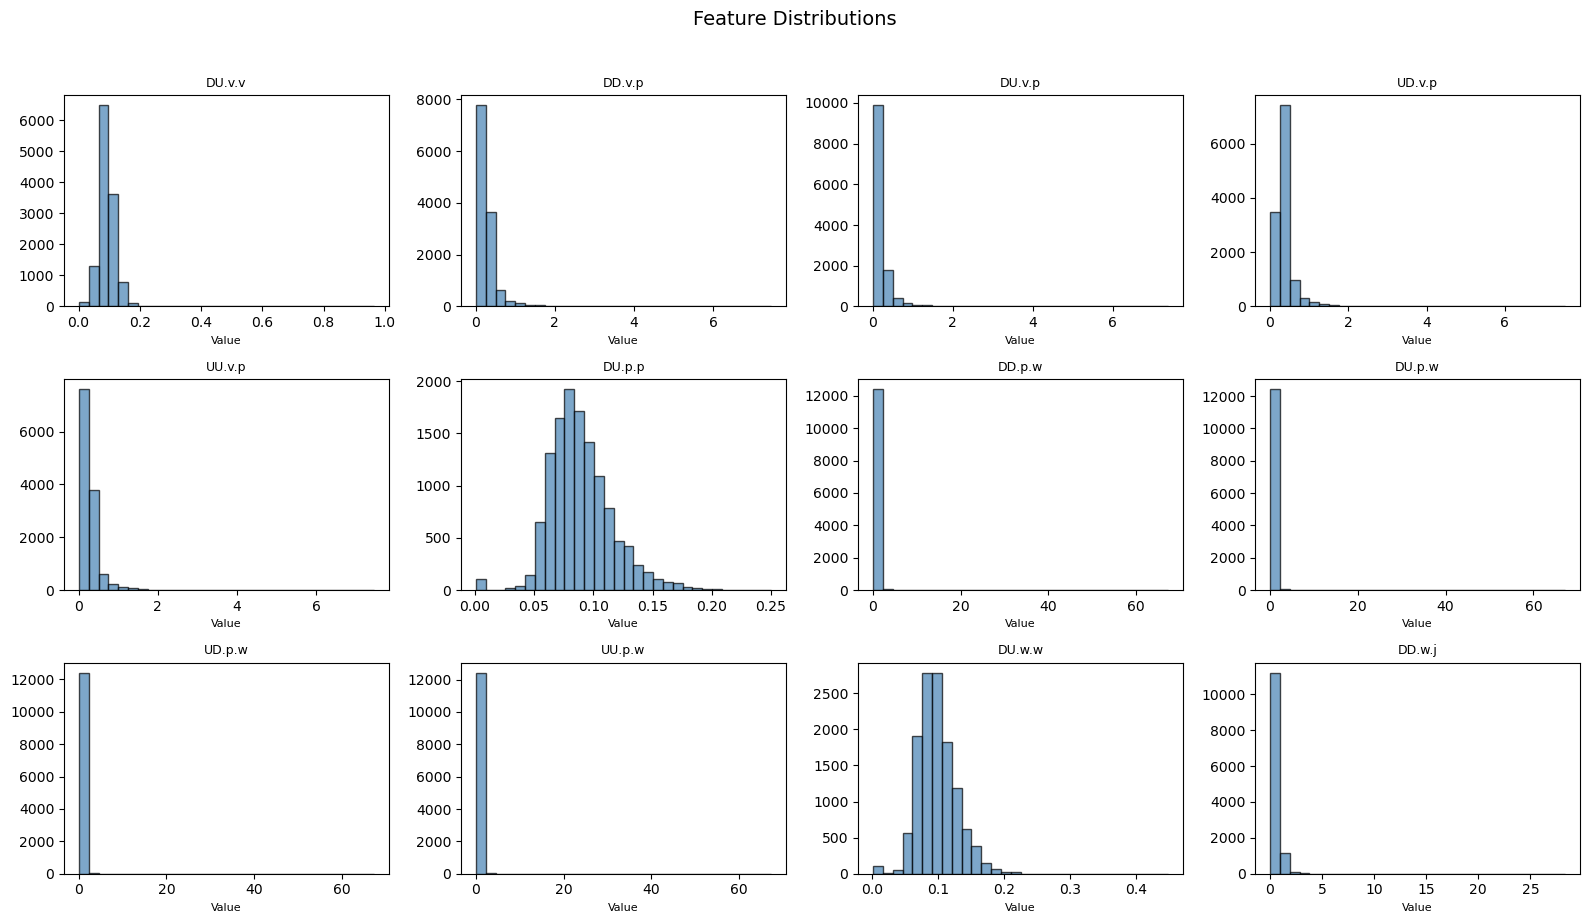

In [5]:
# Plot feature distributions
n_features = min(12, len(timing_cols))
n_rows = (n_features + 3) // 4

fig, axes = plt.subplots(n_rows, 4, figsize=(16, 3*n_rows))
axes = axes.flatten()

for i, col in enumerate(timing_cols[:n_features]):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(col, fontsize=9)
    axes[i].set_xlabel('Value', fontsize=8)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Feature Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Cell 7: EDA - Boxplots (Outlier Detection)

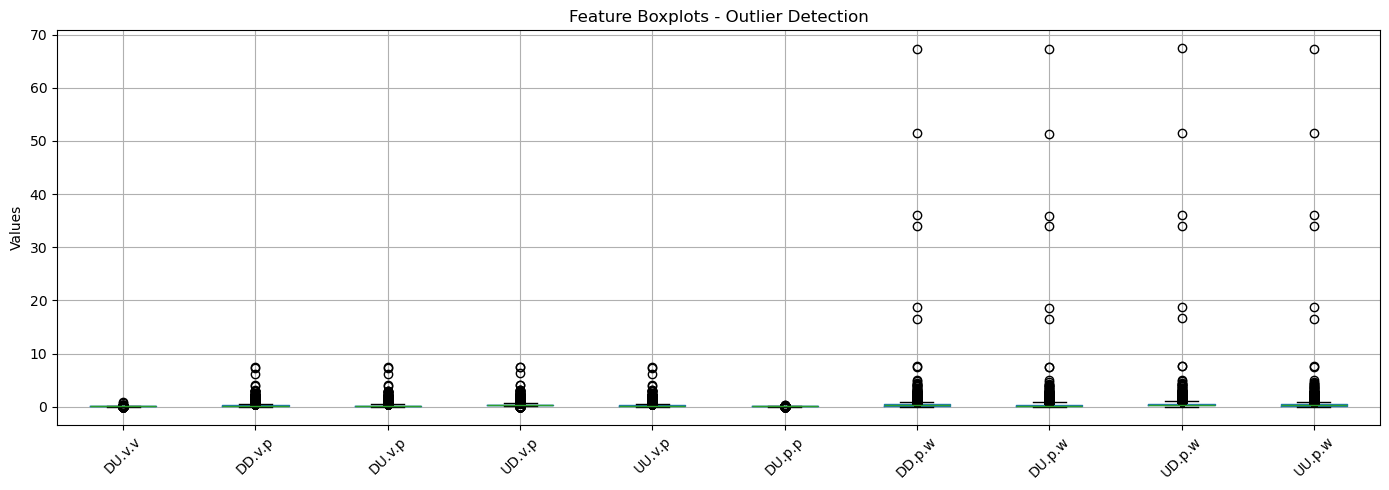

In [6]:
# Boxplots for outlier detection
fig, ax = plt.subplots(figsize=(14, 5))
df[timing_cols[:10]].boxplot(ax=ax, rot=45)
ax.set_title('Feature Boxplots - Outlier Detection')
ax.set_ylabel('Values')
plt.tight_layout()
plt.show()

## Cell 8: EDA - Correlation Heatmap

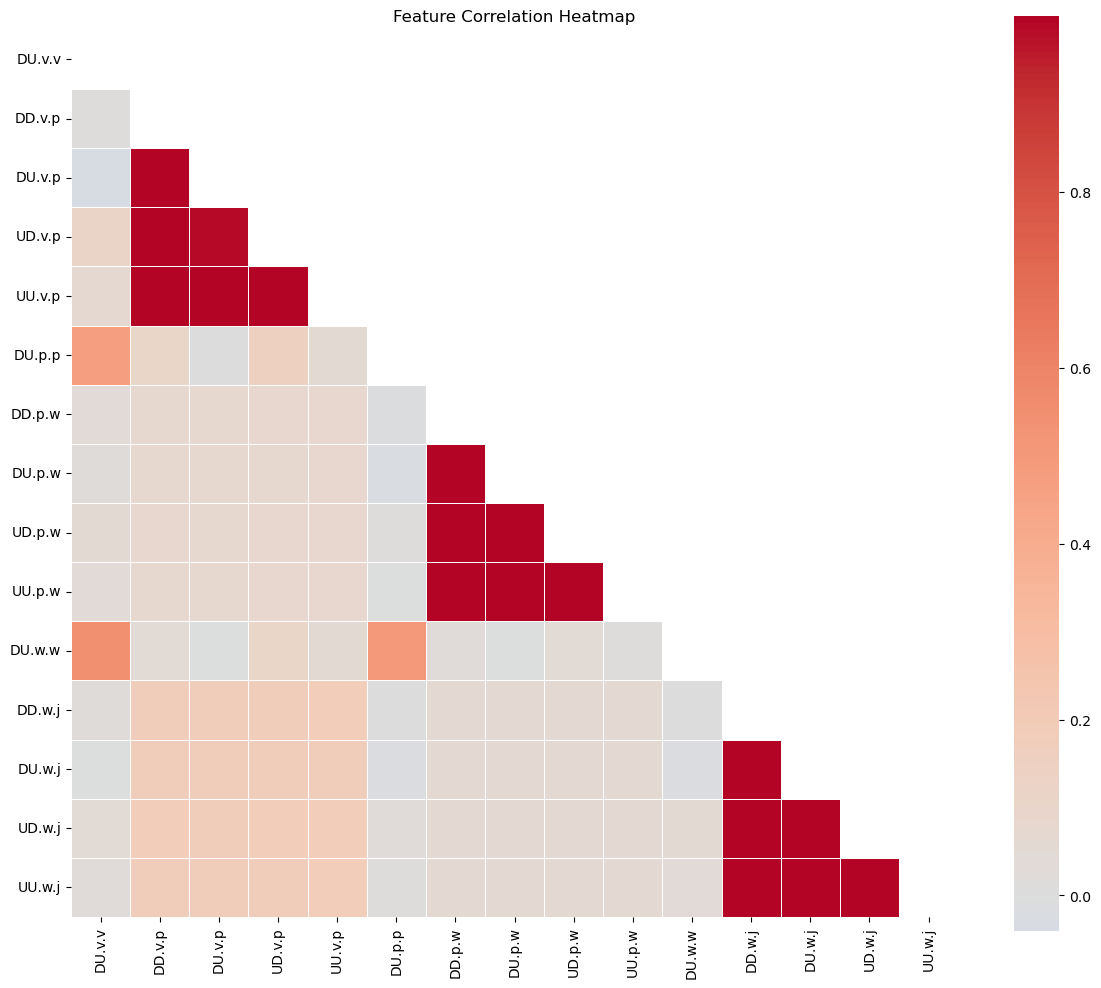

In [7]:
# Correlation heatmap
corr_cols = timing_cols[:15]
corr = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, ax=ax, square=True, 
            annot=False, linewidths=0.5)
ax.set_title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## Cell 9: EDA - Samples per Participant

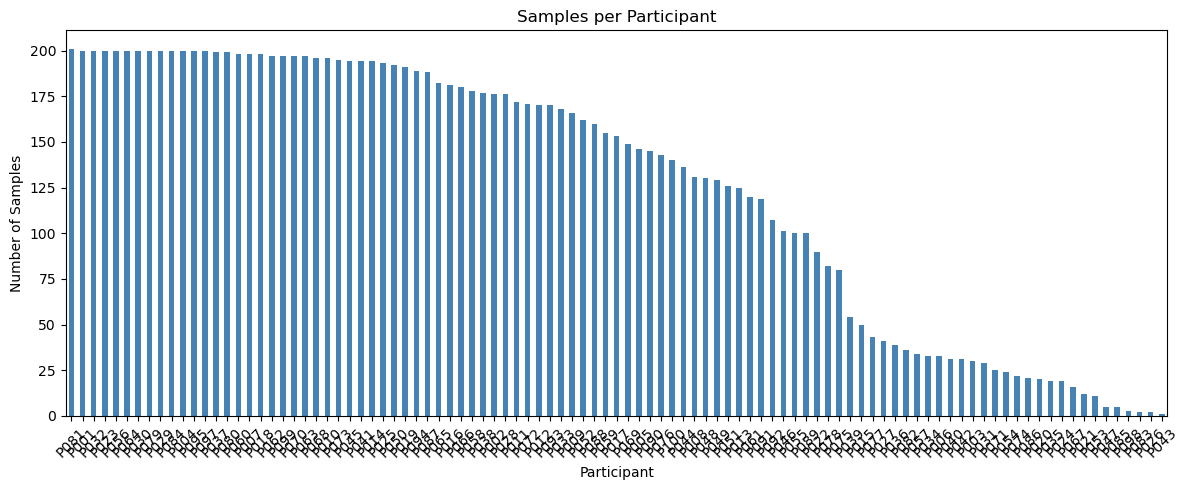

In [8]:
# Samples per participant
fig, ax = plt.subplots(figsize=(12, 5))
df['participant'].value_counts().plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Samples per Participant')
ax.set_xlabel('Participant')
ax.set_ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cell 10: Define Classification Scenarios

We create three labeling scenarios:
1. **Single User Binary**: One user authorized, all others unauthorized
2. **Multi-User Binary**: Multiple users authorized, others unauthorized
3. **Multi-User Multi-Class**: Each authorized user is a separate class

In [10]:
# Get participants
participants = sorted(df['participant'].unique())
print(f"All participants: {participants}")

# Define authorized users
AUTHORIZED_SINGLE = participants[0]  # First participant
AUTHORIZED_MULTI = participants[:4]   # First 4 participants

print(f"\n=== CLASSIFICATION SCENARIOS ===")
print(f"Single User Authorized: {AUTHORIZED_SINGLE}")
print(f"Multi-User Authorized: {AUTHORIZED_MULTI}")

All participants: ['P001', 'P002', 'P003', 'P004', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014', 'P015', 'P016', 'P017', 'P018', 'P019', 'P020', 'P021', 'P022', 'P023', 'P024', 'P025', 'P026', 'P027', 'P028', 'P029', 'P030', 'P031', 'P032', 'P033', 'P034', 'P035', 'P036', 'P037', 'P038', 'P039', 'P040', 'P041', 'P042', 'P043', 'P044', 'P045', 'P046', 'P047', 'P048', 'P049', 'P050', 'P051', 'P052', 'P053', 'P054', 'P055', 'P056', 'P057', 'P058', 'P059', 'P060', 'P061', 'P062', 'P063', 'P064', 'P065', 'P066', 'P067', 'P068', 'P069', 'P070', 'P071', 'P072', 'P073', 'P074', 'P075', 'P076', 'P077', 'P078', 'P079', 'P080', 'P081', 'P082', 'P083', 'P084', 'P085', 'P086', 'P087', 'P088', 'P089', 'P090', 'P091', 'P092', 'P093', 'P094', 'P095', 'P097', 'P098', 'P099', 'P100']

=== CLASSIFICATION SCENARIOS ===
Single User Authorized: P001
Multi-User Authorized: ['P001', 'P002', 'P003', 'P004']


## Cell 11: Create Labels for Each Scenario

In [11]:
# Scenario 1: Single User Binary (0=authorized, 1=unauthorized)
df_single = df.copy()
df_single['label'] = (df_single['participant'] != AUTHORIZED_SINGLE).astype(int)
print("SINGLE USER BINARY:")
print(f"  Authorized: {AUTHORIZED_SINGLE}")
print(f"  Distribution: {dict(Counter(df_single['label']))}")

# Scenario 2: Multi-User Binary (0=authorized, 1=unauthorized)
df_multi_bin = df.copy()
df_multi_bin['label'] = (~df_multi_bin['participant'].isin(AUTHORIZED_MULTI)).astype(int)
print("\nMULTI-USER BINARY:")
print(f"  Authorized: {AUTHORIZED_MULTI}")
print(f"  Distribution: {dict(Counter(df_multi_bin['label']))}")

# Scenario 3: Multi-User Multi-Class
df_multi_class = df.copy()
def assign_multiclass_label(p):
    if p in AUTHORIZED_MULTI:
        return AUTHORIZED_MULTI.index(p)
    return len(AUTHORIZED_MULTI)

df_multi_class['label'] = df_multi_class['participant'].apply(assign_multiclass_label)
CLASS_NAMES = list(AUTHORIZED_MULTI) + ['Unauthorized']
print("\nMULTI-USER MULTI-CLASS:")
print(f"  Classes: {CLASS_NAMES}")
print(f"  Distribution: {dict(Counter(df_multi_class['label']))}")

SINGLE USER BINARY:
  Authorized: P001
  Distribution: {0: 200, 1: 12290}

MULTI-USER BINARY:
  Authorized: ['P001', 'P002', 'P003', 'P004']
  Distribution: {0: 606, 1: 11884}

MULTI-USER MULTI-CLASS:
  Classes: ['P001', 'P002', 'P003', 'P004', 'Unauthorized']
  Distribution: {0: 200, 1: 176, 2: 30, 3: 200, 4: 11884}


## Cell 12: Prepare Features and Split Data (Single User Binary)

DATA SPLIT:
  Training: (9992, 47) - {np.int64(1): 9832, np.int64(0): 160}
  Test: (2498, 47) - {np.int64(1): 2458, np.int64(0): 40}


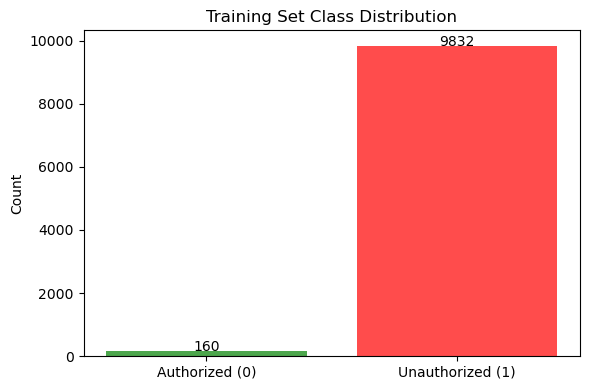

In [12]:
# Extract features and labels
X = df[timing_cols].values
y = df_single['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("DATA SPLIT:")
print(f"  Training: {X_train_scaled.shape} - {dict(Counter(y_train))}")
print(f"  Test: {X_test_scaled.shape} - {dict(Counter(y_test))}")

# Plot class distribution
fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Authorized (0)', 'Unauthorized (1)']
counts = [sum(y_train==0), sum(y_train==1)]
ax.bar(labels, counts, color=['green', 'red'], alpha=0.7)
ax.set_title('Training Set Class Distribution')
ax.set_ylabel('Count')
for i, c in enumerate(counts):
    ax.text(i, c+5, str(c), ha='center')
plt.tight_layout()
plt.show()

## Cell 13: Feature Selection - Mutual Information

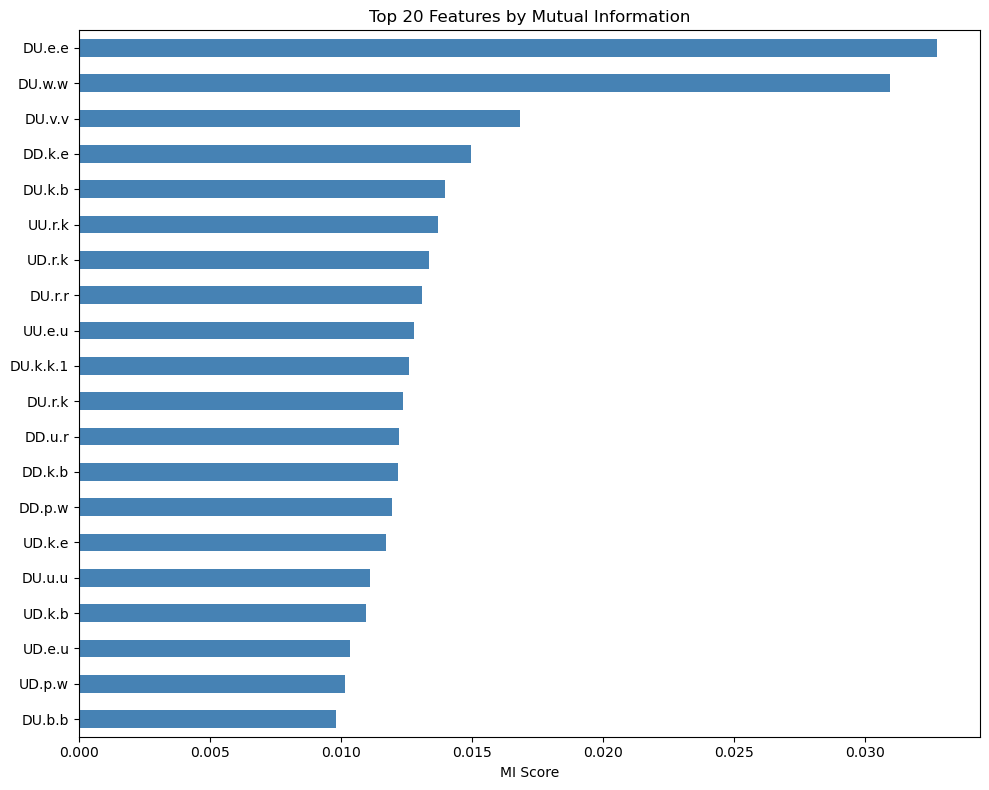


MI Selected Features: ['DU.e.e', 'DU.w.w', 'DU.v.v', 'DD.k.e', 'DU.k.b', 'UU.r.k', 'UD.r.k', 'DU.r.r', 'UU.e.u', 'DU.k.k.1', 'DU.r.k', 'DD.u.r', 'DD.k.b', 'DD.p.w', 'UD.k.e', 'DU.u.u', 'UD.k.b', 'UD.e.u', 'UD.p.w', 'DU.b.b']


In [13]:
# Mutual Information Feature Selection
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)
mi_series = pd.Series(mi_scores, index=timing_cols).sort_values(ascending=False)

# Select top 20 features
N_MI_FEATURES = 20
mi_features = mi_series.head(N_MI_FEATURES).index.tolist()
mi_indices = [timing_cols.index(f) for f in mi_features]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
mi_series.head(N_MI_FEATURES).plot(kind='barh', ax=ax, color='steelblue')
ax.set_title(f'Top {N_MI_FEATURES} Features by Mutual Information')
ax.set_xlabel('MI Score')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nMI Selected Features: {mi_features}")

## Cell 14: Feature Selection - Recursive Feature Elimination (RFE)

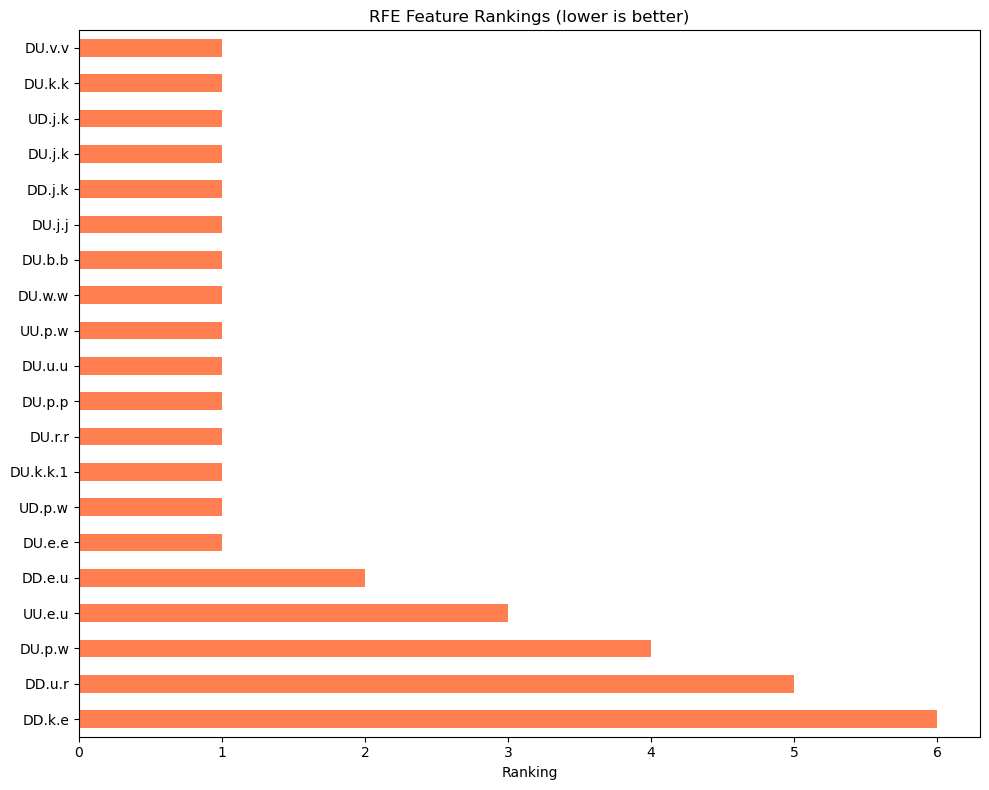


RFE Selected Features (15): ['DU.v.v', 'DU.p.p', 'UD.p.w', 'UU.p.w', 'DU.w.w', 'DU.j.j', 'DD.j.k', 'DU.j.k', 'UD.j.k', 'DU.k.k', 'DU.e.e', 'DU.u.u', 'DU.r.r', 'DU.k.k.1', 'DU.b.b']


In [14]:
# RFE Feature Selection
N_RFE_FEATURES = 15
rfe_estimator = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
rfe = RFE(rfe_estimator, n_features_to_select=N_RFE_FEATURES)
rfe.fit(X_train_scaled, y_train)

rfe_features = [f for f, keep in zip(timing_cols, rfe.support_) if keep]
rfe_indices = [timing_cols.index(f) for f in rfe_features]

# Plot rankings
rankings = pd.Series(rfe.ranking_, index=timing_cols).sort_values()
fig, ax = plt.subplots(figsize=(10, 8))
rankings.head(20).plot(kind='barh', ax=ax, color='coral')
ax.set_title('RFE Feature Rankings (lower is better)')
ax.set_xlabel('Ranking')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nRFE Selected Features ({N_RFE_FEATURES}): {rfe_features}")

## Cell 15: Feature Selection - SelectKBest (F-Score)

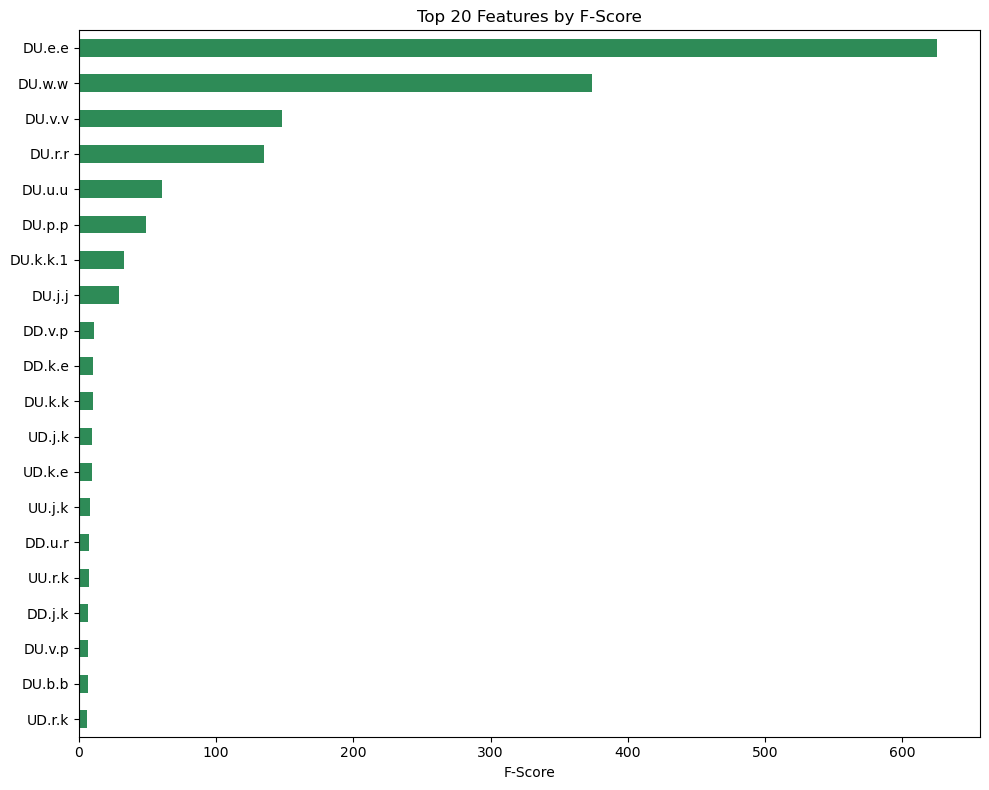


SelectKBest Features: ['DU.e.e', 'DU.w.w', 'DU.v.v', 'DU.r.r', 'DU.u.u', 'DU.p.p', 'DU.k.k.1', 'DU.j.j', 'DD.v.p', 'DD.k.e', 'DU.k.k', 'UD.j.k', 'UD.k.e', 'UU.j.k', 'DD.u.r', 'UU.r.k', 'DD.j.k', 'DU.v.p', 'DU.b.b', 'UD.r.k']


In [15]:
# SelectKBest Feature Selection
N_KBEST_FEATURES = 20
selector = SelectKBest(f_classif, k=N_KBEST_FEATURES)
selector.fit(X_train_scaled, y_train)

kbest_scores = pd.Series(selector.scores_, index=timing_cols).sort_values(ascending=False)
kbest_features = kbest_scores.head(N_KBEST_FEATURES).index.tolist()
kbest_indices = [timing_cols.index(f) for f in kbest_features]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
kbest_scores.head(N_KBEST_FEATURES).plot(kind='barh', ax=ax, color='seagreen')
ax.set_title(f'Top {N_KBEST_FEATURES} Features by F-Score')
ax.set_xlabel('F-Score')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nSelectKBest Features: {kbest_features}")

## Cell 16: Feature Selection - PCA

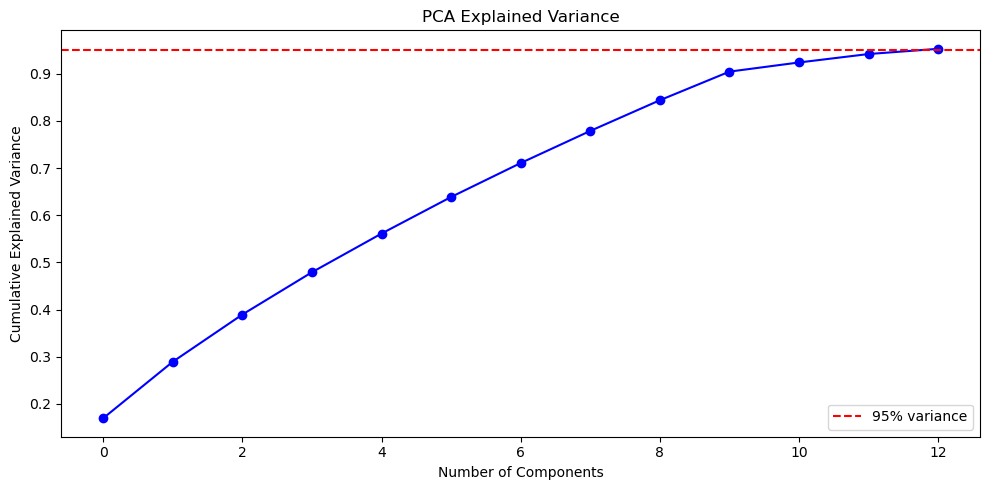


PCA: 47 features → 13 components
Explained variance: 95.31%


In [16]:
# PCA Dimensionality Reduction
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot explained variance
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
ax.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('PCA Explained Variance')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nPCA: {X_train_scaled.shape[1]} features → {X_train_pca.shape[1]} components")
print(f"Explained variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")

## Cell 17: Compare Performance With/Without Feature Selection

In [17]:
# Prepare feature sets
feature_sets = {
    'All Features': (X_train_scaled, X_test_scaled),
    'MI Top 20': (X_train_scaled[:, mi_indices], X_test_scaled[:, mi_indices]),
    'RFE Top 15': (X_train_scaled[:, rfe_indices], X_test_scaled[:, rfe_indices]),
    'SelectKBest 20': (X_train_scaled[:, kbest_indices], X_test_scaled[:, kbest_indices]),
    'PCA 95%': (X_train_pca, X_test_pca)
}

# Compare using Random Forest
fs_results = {}
rf_base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

for name, (X_tr, X_te) in feature_sets.items():
    clf = clone(rf_base)
    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te)[:, 1]
    
    fs_results[name] = {
        'n_features': X_tr.shape[1],
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

fs_df = pd.DataFrame(fs_results).T
print("="*60)
print("FEATURE SELECTION COMPARISON (Random Forest)")
print("="*60)
print(fs_df.round(4).to_string())

FEATURE SELECTION COMPARISON (Random Forest)
                n_features  accuracy      f1  roc_auc
All Features          47.0    0.9972  0.9971   0.9998
MI Top 20             20.0    0.9964  0.9962   0.9998
RFE Top 15            15.0    0.9972  0.9971   0.9994
SelectKBest 20        20.0    0.9964  0.9962   0.9995
PCA 95%               13.0    0.9956  0.9953   0.9995


## Cell 18: Visualize Feature Selection Impact

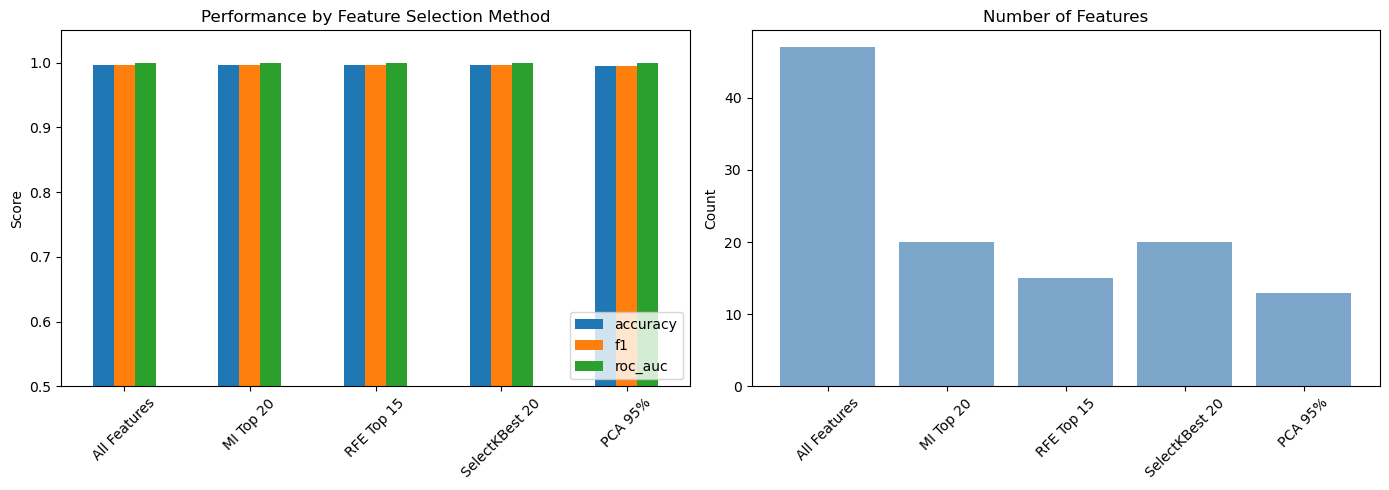

In [18]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance
fs_df[['accuracy', 'f1', 'roc_auc']].plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Performance by Feature Selection Method')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0.5, 1.05)
axes[0].legend(loc='lower right')

# Feature count
axes[1].bar(fs_df.index, fs_df['n_features'], color='steelblue', alpha=0.7)
axes[1].set_title('Number of Features')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Cell 19: Define Base Classifiers

In [19]:
# Define all base classifiers
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    'SVM': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Extra Trees': ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE),
}

if XGBOOST_AVAILABLE:
    base_models['XGBoost'] = XGBClassifier(n_estimators=200, eval_metric='logloss', 
                                           random_state=RANDOM_STATE, use_label_encoder=False)

if LIGHTGBM_AVAILABLE:
    base_models['LightGBM'] = lgb.LGBMClassifier(n_estimators=200, class_weight='balanced', 
                                                  random_state=RANDOM_STATE, verbose=-1)

print(f"Defined {len(base_models)} classifiers:")
for name in base_models.keys():
    print(f"  • {name}")

Defined 12 classifiers:
  • Logistic Regression
  • Random Forest
  • SVM
  • KNN
  • Decision Tree
  • Naive Bayes
  • MLP
  • Gradient Boosting
  • Extra Trees
  • AdaBoost
  • XGBoost
  • LightGBM


## Cell 20: Train and Evaluate Base Classifiers

In [20]:
# Train and evaluate all base models
base_results = {}
base_predictions = {}

print("Training models...")
for name, model in base_models.items():
    print(f"  Training {name}...", end=" ")
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
            'recall': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
            'f1': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        }
        
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            metrics['roc_auc'] = roc_auc_score(y_test, y_prob)
            base_predictions[name] = {'y_pred': y_pred, 'y_prob': y_prob, 'model': model}
        else:
            base_predictions[name] = {'y_pred': y_pred, 'y_prob': None, 'model': model}
        
        base_results[name] = metrics
        print(f"✓ F1={metrics['f1']:.4f}")
    except Exception as e:
        print(f"✗ Error: {e}")

# Create results DataFrame
base_df = pd.DataFrame(base_results).T.sort_values('f1', ascending=False)
print("\n" + "="*70)
print("BASE CLASSIFIER RESULTS (Single User Binary)")
print("="*70)
print(base_df.round(4).to_string())

Training models...
  Training Logistic Regression... ✓ F1=0.9891
  Training Random Forest... ✓ F1=0.9994
  Training SVM... ✓ F1=0.9969
  Training KNN... ✓ F1=0.9990
  Training Decision Tree... ✓ F1=0.9980
  Training Naive Bayes... ✓ F1=0.8315
  Training MLP... ✓ F1=0.9992
  Training Gradient Boosting... ✓ F1=0.9988
  Training Extra Trees... ✓ F1=0.9988
  Training AdaBoost... ✓ F1=0.9996
  Training XGBoost... ✓ F1=0.9996
  Training LightGBM... ✓ F1=0.9996

BASE CLASSIFIER RESULTS (Single User Binary)
                     accuracy  precision  recall      f1  roc_auc
XGBoost                0.9992     0.9996  0.9996  0.9996   0.9993
LightGBM               0.9992     0.9996  0.9996  0.9996   0.9999
AdaBoost               0.9992     1.0000  0.9992  0.9996   0.9998
Random Forest          0.9988     0.9988  1.0000  0.9994   0.9999
MLP                    0.9984     0.9988  0.9996  0.9992   0.9995
KNN                    0.9980     0.9984  0.9996  0.9990   0.9868
Extra Trees            0.9976    

## Cell 21: Visualize Base Classifier Performance

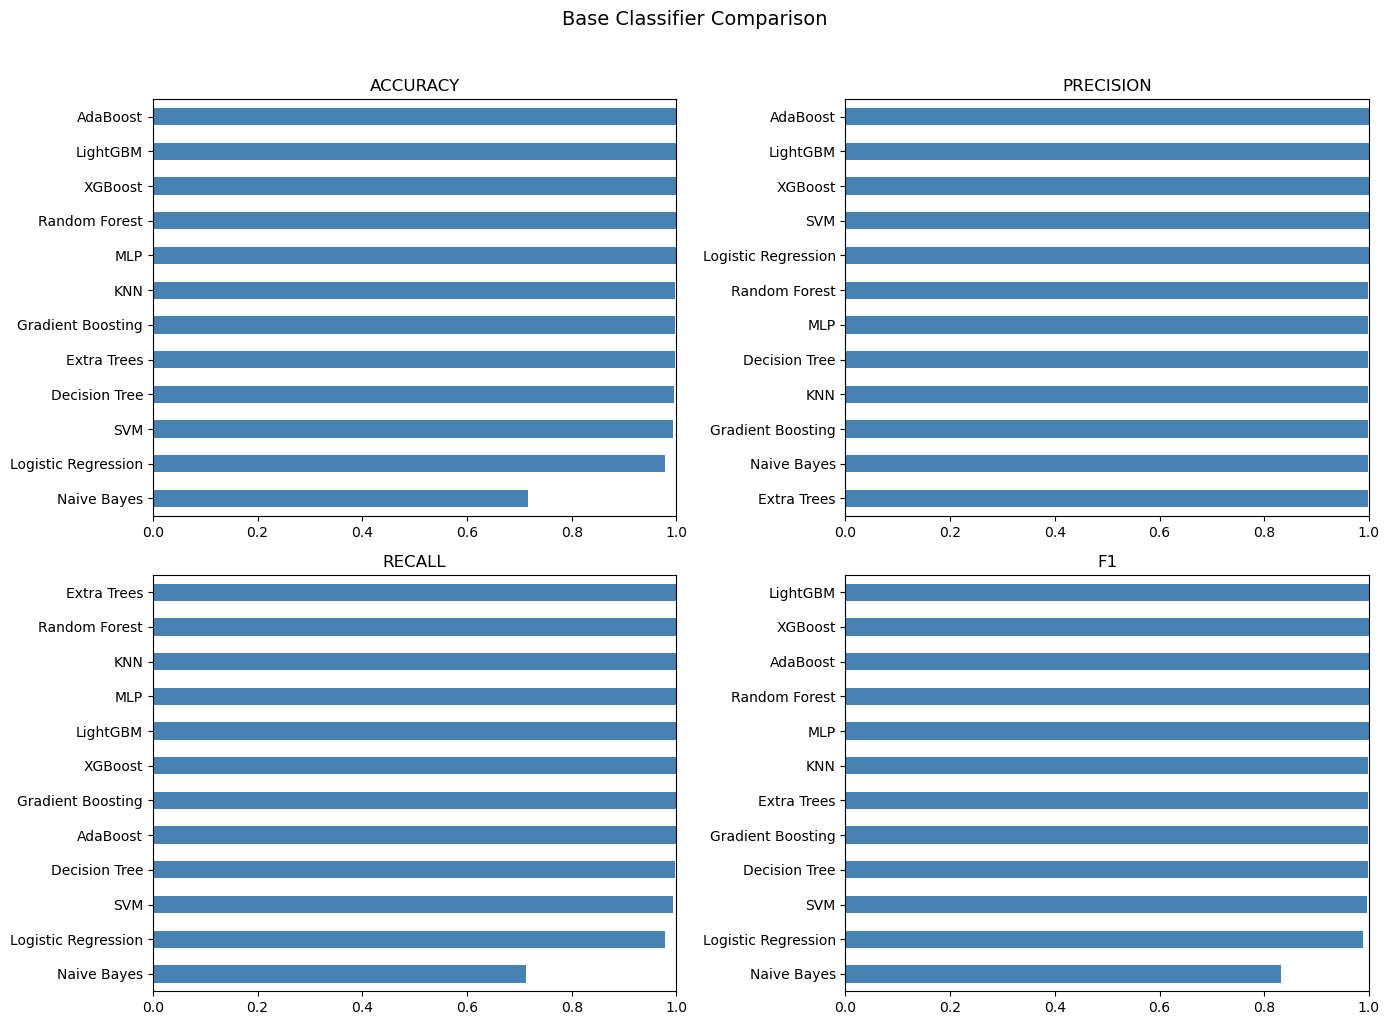

In [21]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    base_df[metric].sort_values().plot(kind='barh', ax=axes[i], color='steelblue')
    axes[i].set_title(metric.upper())
    axes[i].set_xlim(0, 1)

plt.suptitle('Base Classifier Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Cell 22: ROC Curves for Base Classifiers

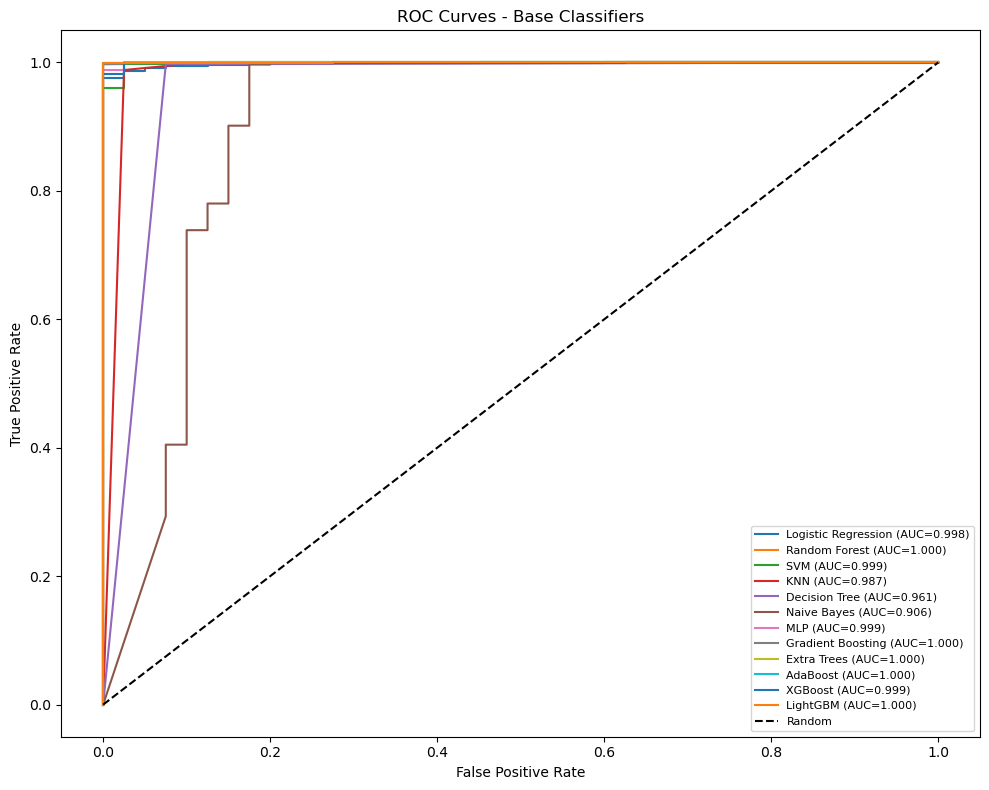

In [22]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, pred in base_predictions.items():
    if pred['y_prob'] is not None:
        fpr, tpr, _ = roc_curve(y_test, pred['y_prob'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Base Classifiers')
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()

## Cell 23: Confusion Matrix for Best Model

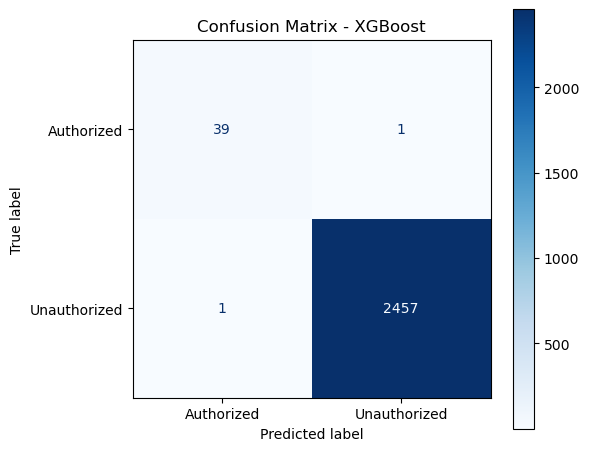


Best Model: XGBoost
              precision    recall  f1-score   support

  Authorized       0.97      0.97      0.97        40
Unauthorized       1.00      1.00      1.00      2458

    accuracy                           1.00      2498
   macro avg       0.99      0.99      0.99      2498
weighted avg       1.00      1.00      1.00      2498



In [23]:
# Confusion matrix for best model
best_name = base_df.index[0]
best_pred = base_predictions[best_name]

cm = confusion_matrix(y_test, best_pred['y_pred'])
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Authorized', 'Unauthorized'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title(f'Confusion Matrix - {best_name}')
plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_name}")
print(classification_report(y_test, best_pred['y_pred'], target_names=['Authorized', 'Unauthorized']))

## Cell 24: Define Ensemble Methods

In [24]:
# Define ensemble classifiers
ensemble_models = {}

# Voting Classifiers
voting_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('svm', SVC(probability=True, random_state=RANDOM_STATE)),
]

if XGBOOST_AVAILABLE:
    voting_estimators.append(('xgb', XGBClassifier(n_estimators=100, eval_metric='logloss', 
                                                    random_state=RANDOM_STATE, use_label_encoder=False)))

ensemble_models['Voting (Hard)'] = VotingClassifier(estimators=voting_estimators, voting='hard', n_jobs=-1)
ensemble_models['Voting (Soft)'] = VotingClassifier(estimators=voting_estimators, voting='soft', n_jobs=-1)

# Bagging
ensemble_models['Bagging'] = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1
)

# Stacking
stack_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=RANDOM_STATE)),
]
if XGBOOST_AVAILABLE:
    stack_estimators.append(('xgb', XGBClassifier(n_estimators=50, eval_metric='logloss', 
                                                   random_state=RANDOM_STATE, use_label_encoder=False)))

ensemble_models['Stacking'] = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5, n_jobs=-1
)

print(f"Defined {len(ensemble_models)} ensemble methods:")
for name in ensemble_models.keys():
    print(f"  • {name}")

Defined 4 ensemble methods:
  • Voting (Hard)
  • Voting (Soft)
  • Bagging
  • Stacking


## Cell 25: Train and Evaluate Ensemble Methods

In [25]:
# Train and evaluate ensemble models
ensemble_results = {}
ensemble_predictions = {}

print("Training ensemble models...")
for name, model in ensemble_models.items():
    print(f"  Training {name}...", end=" ")
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
            'recall': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
            'f1': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        }
        
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            metrics['roc_auc'] = roc_auc_score(y_test, y_prob)
            ensemble_predictions[name] = {'y_pred': y_pred, 'y_prob': y_prob}
        
        ensemble_results[name] = metrics
        print(f"✓ F1={metrics['f1']:.4f}")
    except Exception as e:
        print(f"✗ Error: {e}")

ensemble_df = pd.DataFrame(ensemble_results).T.sort_values('f1', ascending=False)
print("\n" + "="*70)
print("ENSEMBLE METHOD RESULTS")
print("="*70)
print(ensemble_df.round(4).to_string())

Training ensemble models...
  Training Voting (Hard)... ✓ F1=0.9992
  Training Voting (Soft)... ✓ F1=0.9992
  Training Bagging... ✓ F1=0.9986
  Training Stacking... ✓ F1=0.9996

ENSEMBLE METHOD RESULTS
               accuracy  precision  recall      f1  roc_auc
Stacking         0.9992     0.9996  0.9996  0.9996   0.9998
Voting (Hard)    0.9984     0.9988  0.9996  0.9992      NaN
Voting (Soft)    0.9984     0.9988  0.9996  0.9992   0.9997
Bagging          0.9972     0.9984  0.9988  0.9986   0.9985


## Cell 26: Compare Base vs Ensemble Models

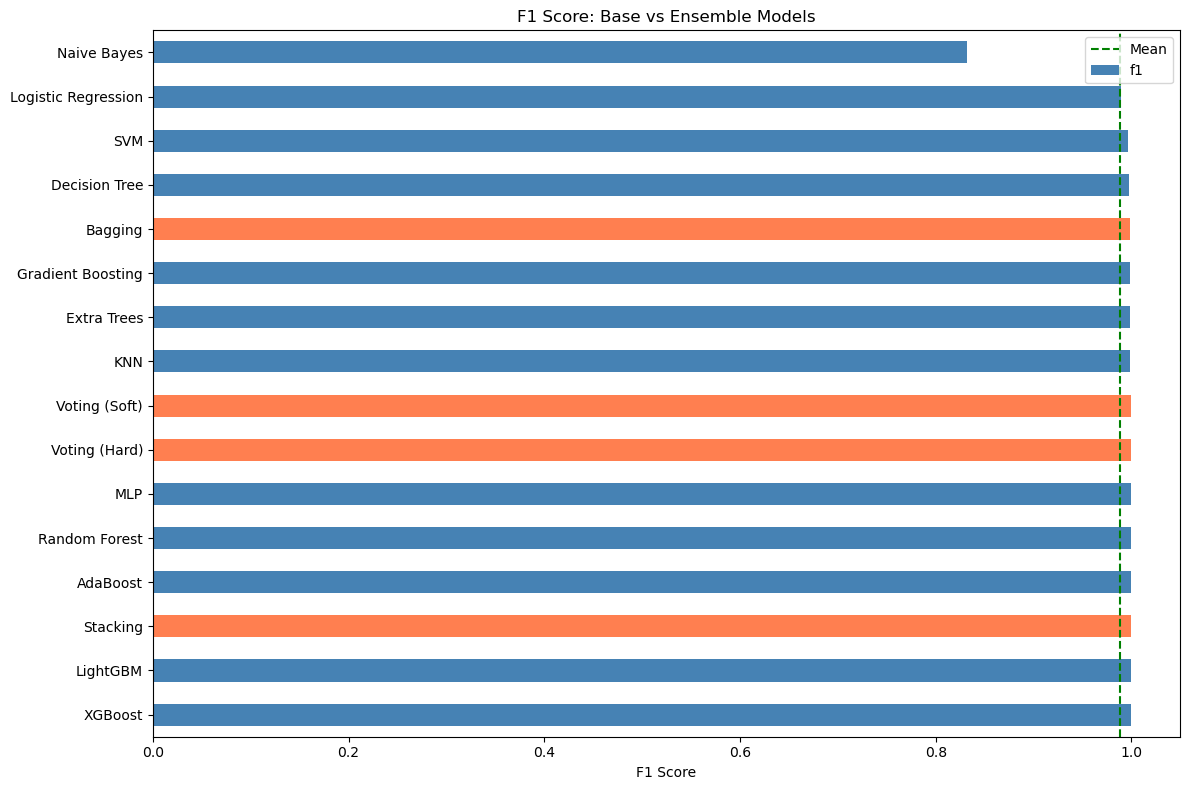


Top 5 Overall Models:
               accuracy      f1  roc_auc      type
XGBoost          0.9992  0.9996   0.9993      Base
LightGBM         0.9992  0.9996   0.9999      Base
Stacking         0.9992  0.9996   0.9998  Ensemble
AdaBoost         0.9992  0.9996   0.9998      Base
Random Forest    0.9988  0.9994   0.9999      Base


In [26]:
# Combine results
all_results = pd.concat([
    base_df.assign(type='Base'),
    ensemble_df.assign(type='Ensemble')
]).sort_values('f1', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['steelblue' if t == 'Base' else 'coral' for t in all_results['type']]
all_results['f1'].plot(kind='barh', ax=ax, color=colors)
ax.set_title('F1 Score: Base vs Ensemble Models')
ax.set_xlabel('F1 Score')
ax.axvline(x=all_results['f1'].mean(), color='green', linestyle='--', label='Mean')
ax.legend()
plt.tight_layout()
plt.show()

print("\nTop 5 Overall Models:")
print(all_results.head(5)[['accuracy', 'f1', 'roc_auc', 'type']].round(4).to_string())

## Cell 27: Cross-Validation Analysis

5-Fold Cross-Validation Results:
--------------------------------------------------
Random Forest: 0.9976 (+/- 0.0016)
Gradient Boosting: 0.9985 (+/- 0.0013)
Voting (Soft): 0.9987 (+/- 0.0007)
XGBoost: 0.9987 (+/- 0.0011)
LightGBM: 0.9988 (+/- 0.0010)


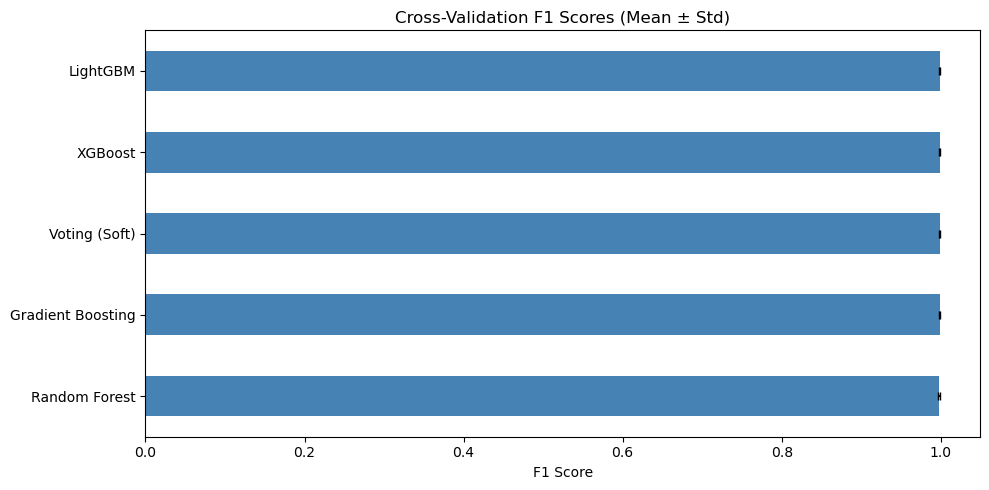

In [27]:
# Cross-validation for top models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Voting (Soft)': ensemble_models['Voting (Soft)'],
}
if XGBOOST_AVAILABLE:
    cv_models['XGBoost'] = XGBClassifier(n_estimators=200, eval_metric='logloss', 
                                          random_state=RANDOM_STATE, use_label_encoder=False)
if LIGHTGBM_AVAILABLE:
    cv_models['LightGBM'] = lgb.LGBMClassifier(n_estimators=200, random_state=RANDOM_STATE, verbose=-1)

print("5-Fold Cross-Validation Results:")
print("-" * 50)
cv_results = {}
for name, model in cv_models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1', n_jobs=-1)
    cv_results[name] = {'mean': scores.mean(), 'std': scores.std()}
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# Plot
cv_df = pd.DataFrame(cv_results).T
fig, ax = plt.subplots(figsize=(10, 5))
cv_df['mean'].sort_values().plot(kind='barh', xerr=cv_df['std'], ax=ax, color='steelblue', capsize=3)
ax.set_title('Cross-Validation F1 Scores (Mean ± Std)')
ax.set_xlabel('F1 Score')
plt.tight_layout()
plt.show()

## Cell 28: Multi-User Binary Classification

Multiple users (first 4 participants) as authorized, all others as unauthorized.

In [28]:
# Prepare multi-user binary data
y_mb = df_multi_bin['label'].values

X_train_mb, X_test_mb, y_train_mb, y_test_mb = train_test_split(
    X, y_mb, test_size=0.2, stratify=y_mb, random_state=RANDOM_STATE
)

scaler_mb = StandardScaler()
X_train_mb_scaled = scaler_mb.fit_transform(X_train_mb)
X_test_mb_scaled = scaler_mb.transform(X_test_mb)

print("MULTI-USER BINARY CLASSIFICATION")
print(f"Authorized users: {AUTHORIZED_MULTI}")
print(f"Training: {X_train_mb_scaled.shape} - {dict(Counter(y_train_mb))}")
print(f"Test: {X_test_mb_scaled.shape} - {dict(Counter(y_test_mb))}")

MULTI-USER BINARY CLASSIFICATION
Authorized users: ['P001', 'P002', 'P003', 'P004']
Training: (9992, 47) - {np.int64(1): 9507, np.int64(0): 485}
Test: (2498, 47) - {np.int64(1): 2377, np.int64(0): 121}


## Cell 29: Train Models for Multi-User Binary

In [29]:
# Train selected models
mb_models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Voting (Soft)': VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
            ('gb', GradientBoostingClassifier(n_estimators=50, random_state=RANDOM_STATE)),
        ],
        voting='soft', n_jobs=-1
    ),
}
if XGBOOST_AVAILABLE:
    mb_models['XGBoost'] = XGBClassifier(n_estimators=200, eval_metric='logloss', 
                                          random_state=RANDOM_STATE, use_label_encoder=False)

mb_results = {}
mb_predictions = {}

print("Training models for Multi-User Binary...")
for name, model in mb_models.items():
    model.fit(X_train_mb_scaled, y_train_mb)
    y_pred = model.predict(X_test_mb_scaled)
    y_prob = model.predict_proba(X_test_mb_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    mb_results[name] = {
        'accuracy': accuracy_score(y_test_mb, y_pred),
        'precision': precision_score(y_test_mb, y_pred, pos_label=1),
        'recall': recall_score(y_test_mb, y_pred, pos_label=1),
        'f1': f1_score(y_test_mb, y_pred, pos_label=1),
        'roc_auc': roc_auc_score(y_test_mb, y_prob) if y_prob is not None else np.nan
    }
    mb_predictions[name] = {'y_pred': y_pred, 'y_prob': y_prob}
    print(f"  {name}: F1={mb_results[name]['f1']:.4f}")

mb_df = pd.DataFrame(mb_results).T.sort_values('f1', ascending=False)
print("\n" + "="*70)
print("MULTI-USER BINARY RESULTS")
print("="*70)
print(mb_df.round(4).to_string())

Training models for Multi-User Binary...
  Random Forest: F1=0.9871
  Gradient Boosting: F1=0.9885
  Voting (Soft): F1=0.9865
  XGBoost: F1=0.9916

MULTI-USER BINARY RESULTS
                   accuracy  precision  recall      f1  roc_auc
XGBoost              0.9840     0.9855  0.9979  0.9916   0.9912
Gradient Boosting    0.9780     0.9790  0.9983  0.9885   0.9699
Random Forest        0.9752     0.9746  1.0000  0.9871   0.9828
Voting (Soft)        0.9740     0.9742  0.9992  0.9865   0.9781


## Cell 30: Multi-User Binary - Best Model Confusion Matrix

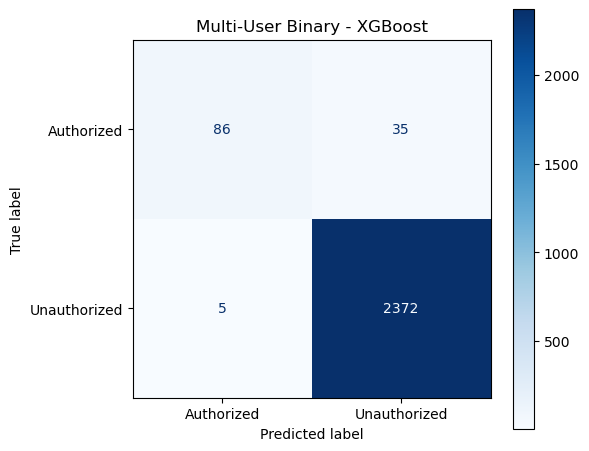


Best Model: XGBoost
              precision    recall  f1-score   support

  Authorized       0.95      0.71      0.81       121
Unauthorized       0.99      1.00      0.99      2377

    accuracy                           0.98      2498
   macro avg       0.97      0.85      0.90      2498
weighted avg       0.98      0.98      0.98      2498



In [30]:
# Confusion matrix for best multi-user binary model
best_mb_name = mb_df.index[0]
best_mb_pred = mb_predictions[best_mb_name]

cm_mb = confusion_matrix(y_test_mb, best_mb_pred['y_pred'])
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mb, display_labels=['Authorized', 'Unauthorized'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title(f'Multi-User Binary - {best_mb_name}')
plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_mb_name}")
print(classification_report(y_test_mb, best_mb_pred['y_pred'], target_names=['Authorized', 'Unauthorized']))

## Cell 31: Multi-User Multi-Class Classification

Each authorized user as a separate class + 'Unauthorized' class.

In [31]:
# Prepare multi-class data
y_mc = df_multi_class['label'].values

X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X, y_mc, test_size=0.2, stratify=y_mc, random_state=RANDOM_STATE
)

scaler_mc = StandardScaler()
X_train_mc_scaled = scaler_mc.fit_transform(X_train_mc)
X_test_mc_scaled = scaler_mc.transform(X_test_mc)

print("MULTI-USER MULTI-CLASS CLASSIFICATION")
print(f"Classes: {CLASS_NAMES}")
print(f"Training: {X_train_mc_scaled.shape}")
print(f"Class distribution (train): {dict(Counter(y_train_mc))}")

MULTI-USER MULTI-CLASS CLASSIFICATION
Classes: ['P001', 'P002', 'P003', 'P004', 'Unauthorized']
Training: (9992, 47)
Class distribution (train): {np.int64(4): 9507, np.int64(2): 24, np.int64(1): 141, np.int64(0): 160, np.int64(3): 160}


## Cell 32: Train Models for Multi-Class Classification

In [32]:
# Train models for multi-class
mc_models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'MLP': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=RANDOM_STATE),
}
if XGBOOST_AVAILABLE:
    mc_models['XGBoost'] = XGBClassifier(n_estimators=200, eval_metric='mlogloss', 
                                          random_state=RANDOM_STATE, use_label_encoder=False)

mc_results = {}
mc_predictions = {}

print("Training models for Multi-Class...")
for name, model in mc_models.items():
    model.fit(X_train_mc_scaled, y_train_mc)
    y_pred = model.predict(X_test_mc_scaled)
    
    mc_results[name] = {
        'accuracy': accuracy_score(y_test_mc, y_pred),
        'precision': precision_score(y_test_mc, y_pred, average='weighted'),
        'recall': recall_score(y_test_mc, y_pred, average='weighted'),
        'f1': f1_score(y_test_mc, y_pred, average='weighted'),
    }
    mc_predictions[name] = {'y_pred': y_pred, 'model': model}
    print(f"  {name}: F1={mc_results[name]['f1']:.4f}")

mc_df = pd.DataFrame(mc_results).T.sort_values('f1', ascending=False)
print("\n" + "="*70)
print("MULTI-CLASS RESULTS")
print("="*70)
print(mc_df.round(4).to_string())

Training models for Multi-Class...
  Random Forest: F1=0.9812
  Gradient Boosting: F1=0.9868
  MLP: F1=0.9787
  XGBoost: F1=0.9896

MULTI-CLASS RESULTS
                   accuracy  precision  recall      f1
XGBoost              0.9904     0.9905  0.9904  0.9896
Gradient Boosting    0.9876     0.9872  0.9876  0.9868
Random Forest        0.9836     0.9835  0.9836  0.9812
MLP                  0.9796     0.9784  0.9796  0.9787


## Cell 33: Multi-Class - Best Model Confusion Matrix

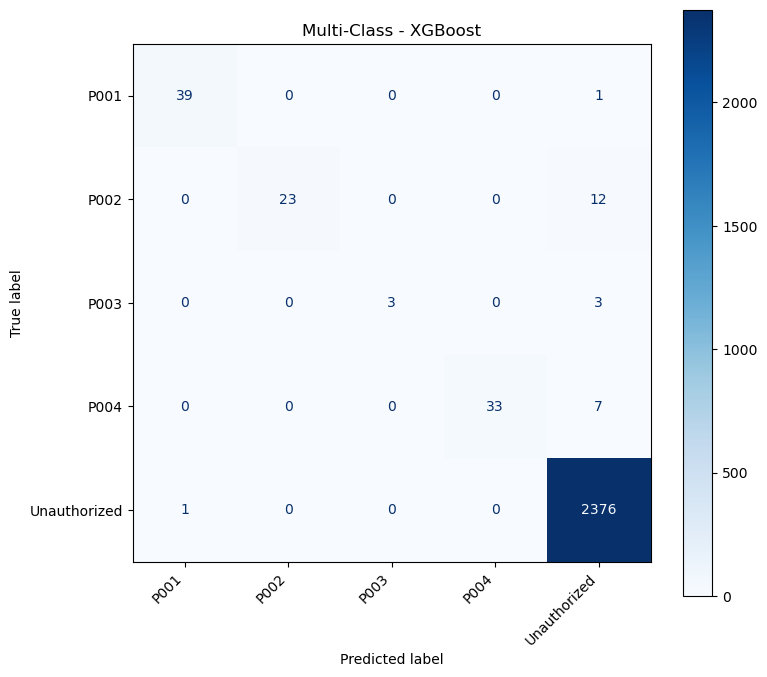


Best Model: XGBoost
              precision    recall  f1-score   support

        P001       0.97      0.97      0.97        40
        P002       1.00      0.66      0.79        35
        P003       1.00      0.50      0.67         6
        P004       1.00      0.82      0.90        40
Unauthorized       0.99      1.00      0.99      2377

    accuracy                           0.99      2498
   macro avg       0.99      0.79      0.87      2498
weighted avg       0.99      0.99      0.99      2498



In [33]:
# Confusion matrix for best multi-class model
best_mc_name = mc_df.index[0]
best_mc_pred = mc_predictions[best_mc_name]

cm_mc = confusion_matrix(y_test_mc, best_mc_pred['y_pred'])
fig, ax = plt.subplots(figsize=(8, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mc, display_labels=CLASS_NAMES)
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title(f'Multi-Class - {best_mc_name}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_mc_name}")
print(classification_report(y_test_mc, best_mc_pred['y_pred'], target_names=CLASS_NAMES))

## Cell 34: Final Summary Report

In [34]:
print("="*80)
print("KEYSTROKE DYNAMICS AUTHENTICATION - FINAL SUMMARY")
print("="*80)

print("\n" + "="*60)
print("1. SINGLE USER BINARY (Top 5)")
print("="*60)
print(base_df.head(5).round(4).to_string())

print("\n" + "="*60)
print("2. ENSEMBLE METHODS")
print("="*60)
print(ensemble_df.round(4).to_string())

print("\n" + "="*60)
print("3. FEATURE SELECTION IMPACT")
print("="*60)
print(fs_df.round(4).to_string())

print("\n" + "="*60)
print("4. MULTI-USER BINARY")
print("="*60)
print(mb_df.round(4).to_string())

print("\n" + "="*60)
print("5. MULTI-CLASS")
print("="*60)
print(mc_df.round(4).to_string())

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"• Best single-user binary: {base_df.index[0]} (F1: {base_df.iloc[0]['f1']:.4f})")
print(f"• Best ensemble: {ensemble_df.index[0]} (F1: {ensemble_df.iloc[0]['f1']:.4f})")
print(f"• Best feature selection: {fs_df['f1'].idxmax()} (F1: {fs_df['f1'].max():.4f})")
print(f"• Best multi-user binary: {mb_df.index[0]} (F1: {mb_df.iloc[0]['f1']:.4f})")
print(f"• Best multi-class: {mc_df.index[0]} (F1: {mc_df.iloc[0]['f1']:.4f})")
print("="*80)

KEYSTROKE DYNAMICS AUTHENTICATION - FINAL SUMMARY

1. SINGLE USER BINARY (Top 5)
               accuracy  precision  recall      f1  roc_auc
XGBoost          0.9992     0.9996  0.9996  0.9996   0.9993
LightGBM         0.9992     0.9996  0.9996  0.9996   0.9999
AdaBoost         0.9992     1.0000  0.9992  0.9996   0.9998
Random Forest    0.9988     0.9988  1.0000  0.9994   0.9999
MLP              0.9984     0.9988  0.9996  0.9992   0.9995

2. ENSEMBLE METHODS
               accuracy  precision  recall      f1  roc_auc
Stacking         0.9992     0.9996  0.9996  0.9996   0.9998
Voting (Hard)    0.9984     0.9988  0.9996  0.9992      NaN
Voting (Soft)    0.9984     0.9988  0.9996  0.9992   0.9997
Bagging          0.9972     0.9984  0.9988  0.9986   0.9985

3. FEATURE SELECTION IMPACT
                n_features  accuracy      f1  roc_auc
All Features          47.0    0.9972  0.9971   0.9998
MI Top 20             20.0    0.9964  0.9962   0.9998
RFE Top 15            15.0    0.9972  0.9971   